# Groupe E - Projet de Deep Learning 

Luis Dierick, Tom Marchal

## Mise en place

Pour réaliser ce projet, nous avons besoin de plusieurs librairies python. A savoir principalement : 
- PyTorch et Scikit Learn pour pouvoir créer notre CNN et utiliser des fonctions utiles en machine learning
- Numpy pour manipuler et calculer certaines caractéristiques sur des tableaux
- Matplotlib pour visualiser nos résultats

Pour information, le modèle a été entrainé sur un GPU Intel d'où la présence du module `intel_extension_for_pytorch` qui permet d'utiliser l'accelération GPU et optimiser les calculs sur celle-ci.

On definit également certaines variables qui resteront constantes durant l'entrainement.

In [23]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms.v2 as T2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler

import intel_extension_for_pytorch as ipex


device = 'xpu' if torch.xpu.is_available() else 'cpu' # Utilise la carte graphique, si GPU intel est disponible


NB_CLASSES = 8
CLASSES = ['battery', 'cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'textile']
NB_EPOCHS = 50
BATCH_SIZE = 64
DTYPE = torch.bfloat16
LR = 0.001
L1_REG = 0.01
TRAIN_DATA = "./waste-classification-challenge/train/train/"
TEST_DATA = "./waste-classification-challenge/test/test/"


## Données
Au niveau des données, nous avons reçu initialement $\approx$ 8000 images de déchets. Le set d'entrainement contient $\approx$ 5500 images labbelées en 8 catégories (battery, cardboard, glass, metal, organic, paper, plastic, textile). Les $\approx$ 2500 images restantes ne sont pas labbelées et servent à soumettre nos predictions pour la competition Kaggle.




In [24]:
train_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.RandomHorizontalFlip(),
        T2.RandomVerticalFlip(),
        T2.RandomRotation(degrees=30),
        T2.RandomChannelPermutation(),
        T2.RandomResizedCrop(224, scale=(0.6, 1), antialias=True),
        T2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5)),
        T2.GaussianBlur(kernel_size=(3, 9)),
    ]
).to(device)

test_transform = T2.Compose(
    [
        T2.ToImage(),
        T2.ToDtype(DTYPE),
        T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T2.Resize(224, antialias=True),
        T2.CenterCrop(224),
    ]
).to(device)

dataset = ImageFolder(root=TRAIN_DATA)
    
    

Avant tout, observons la distribution des données en termes de categories afin de voir si certaines précoutions devrons être prises avant l'entrainement d'un modèle.

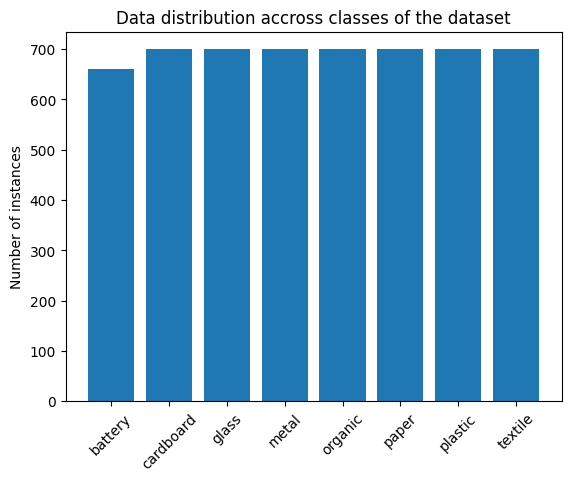

In [25]:
# Data distribution
x = np.arange(NB_CLASSES)
y = []
for i in range(NB_CLASSES):
    y.append(dataset.targets.count(i))

plt.title("Data distribution accross classes of the dataset")
plt.bar(x, y)
plt.xticks(x, CLASSES, rotation=45)
plt.ylabel("Number of instances")
plt.show()


### Préprocessing
Pour entrainer le modèle, on ne travaille pas directement sur l'image mais sur une représentation de celle sous forme d'une matrice (Tensor). Les variables `train_transform` et `test_transform` permettent de réaliser ces transformations en plus de les normaliser.

### Expension du dataset

Afin de d'améliorer au mieux la qualité de notre modèle, nous avons augmenter artificilement la taille du dataset. Grâce à la fonction transmorm de PyTorch nous pouvons facilement modifier nos images d'origines. Chaque image sera modifiée comme suit:

1. Une probabilité de 0.5 d'avoir un retournement horizontal et vertical.
2. Une rotation allant de -30 à 30 degrées
3. Une redimension aléatoire d'une taille allant de 134x134 pixels à 224x224 pixels
4. Des modifications de contraste, luminosité et de saturation
5. Et enfin, un flou Gaussien

Ces transormations sont appliquées uniquement aux images prévues à l'entrainement. Les images de validation par contre, sont utilisées sans modifications afin de se rendre compte du comportement en situation réelle du modèle.


## Campagne de selection d'un modèle

### Procédure globale

Le workflow est le suivant : on sépare les données d'entrainements en un set d'entrainement et un set de validation. Ce set de validation permet d'evaluer les performances de nos modèles afin de pouvoir trouver le plus approprié. Une fois le modèle bien définit, on le réentrainera une nouvelle fois mais sur l'intégralité des données cette fois ci.

Afin de trouver une architecture adaptée à notre objectif, nous nous sommes inspiré de modèles de classifcation d'images existant. Dans notre cas, on s'est innspiré de VGG11. En partant de sa structure de base, nous avons essayé de l'adapter au mieux afin d'obtenir les meilleures performances possibles.


### Modèle final
Notre modèle final est composé de la manière suivante : 



In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Dropout(0.3)

        )
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(256),
            # nn.Dropout(0.3),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.BatchNorm1d(128),
            # nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimentions in one
        x = torch.flatten(x, 1)
        
        # Classifiy the image
        x = self.classifier(x)
        return x
    

Au niveau de la loss, on utilise l'entropie
L'adaptation des poids se fera vie une descente de gradients.

Encore une fois ici, la libraire `ipex` permet d'optimiser les calculs réaliser au sein du GPU si le modèle est entrainé en 16 bits.

In [27]:
model = CustomCNN(num_classes=NB_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.01)
model = model.to(device)
criterion = criterion.to(device)
if device == 'xpu':
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=DTYPE)

### Entrainement
Ci-dessous se trouve la fonction d'entrainement prenant un paramètre le modèle et un set de batchs correspondant à une époque. Elle calculera pour chaque instance, une sortie au modèle et va en fonction de la valeur de loss faire de la rétroprobagation afin de recalculer les nouveaux poids du réseau de neurones.

Cette fonction va à la fin renvoyer le modèle avec les poids à jour et 2 listes contenant les valeurs d'accuracy et de loss pour l'époque venant d'avoir lieu.

In [28]:
def train_epoch(model, train_loader):
    ########## Training ##########
    model.train()

    train_n_corrects = 0
    train_n_total = 0
    train_losses = []

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target)
            _, predicted = torch.max(output, 1)

            # L1_term = torch.tensor(0., requires_grad=True)
            # for name, weights in model.named_parameters():
            #     if 'bias' not in name:
            #         weights_sum = torch.sum(torch.abs(weights))
            #     L1_term = L1_term + weights_sum

            # L1_term = L1_term / nweights
            # loss = loss + L1_REG * L1_term


        train_n_corrects += (predicted == target).sum().item()
        train_n_total += target.numel()
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_epoch_acc = train_n_corrects / train_n_total
    train_epoch_loss = np.mean(train_losses).__float__()

    ########## Print results ##########
    print(f"Train accuracy: {train_epoch_acc}")
    print(f"Train loss: {train_epoch_loss}")
    print("--------------------")

    return model, train_epoch_acc, train_epoch_loss

Maintenant, la fonction de validation qui prend les mêmes paramètres que la fonction `train_epoch()` sauf que celle si prendra en plus 2 listes vides. La première servira à récupérer les valeur à prédire chaque instance d'image. La seconde gardera en mémoire les la classe prédite par le modèle pour ces images.

In [29]:
def test_model(model, test_loader, val_values, val_predictions):
    ########## Testing ##########
        model.eval()
        test_n_corrects = 0
        test_n_total = 0
        test_losses = []
        
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)
                _, predicted = torch.max(output, 1)

                val_values.append(target)
                val_predictions.append(predicted)
                test_n_corrects += (predicted == target).sum().item()
                test_n_total += target.numel()
                test_losses.append(loss.item())

        test_epoch_acc = test_n_corrects / test_n_total
        test_epoch_loss = np.mean(test_losses).__float__()

        #### Print results ####
        print(f"Test accuracy: {test_n_corrects / test_n_total}")
        print(f"Test loss: {np.mean(test_losses)}")
        print("--------------------")

        return test_epoch_acc, test_epoch_loss, val_values, val_predictions

In [30]:
def train_model(model, full_dataset):

    if full_dataset:
        dataset.transform = train_transform
        sampler = RandomSampler(dataset)
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

    elif not full_dataset:
        train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
        train_dataset.dataset.transform = train_transform
        test_dataset.dataset.transform = test_transform
        train_sampler = RandomSampler(train_dataset)
        test_sampler = RandomSampler(test_dataset)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


    train_graph_acc = []
    train_graph_loss = []
    test_graph_acc = []
    test_graph_loss = []

    val_values = []
    val_predictions = []


    # nweights = 0
    # for name,weights in model.named_parameters():
    #     if 'bias' not in name:
    #         nweights = nweights + weights.numel()
        

    for epoch in range(NB_EPOCHS):
        print(f"Epoch {epoch}")
        model, train_epoch_acc, train_epoch_loss = train_epoch(model, train_loader)

        if not full_dataset:
            val_values = []
            val_predictions = []

            test_epoch_acc, test_epoch_loss, val_values, val_predictions = test_model(model, test_loader, val_values, val_predictions)
            
            train_graph_acc.append(train_epoch_acc)
            train_graph_loss.append(train_epoch_loss)
            test_graph_acc.append(test_epoch_acc)
            test_graph_loss.append(test_epoch_loss)
    
    
    if not full_dataset:
        ########## Visualise results ##########
        x = np.arange(1, NB_EPOCHS + 1)
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Number of epochs')
        ax1.set_ylabel('Accuracy')
        ax1.plot(x, train_graph_acc, label='Train Accuracy', color='tab:blue')
        ax1.plot(x, test_graph_acc, label='Test Accuracy', color='tab:cyan')
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Loss')
        ax2.plot(x, train_graph_loss, label='Train Loss', color='tab:green')
        ax2.plot(x, test_graph_loss, label='Test Loss', color='tab:olive')
        ax2.tick_params(axis='y')
        fig.legend()
        plt.show()

        plt.figure()
        cm = confusion_matrix(torch.cat(val_values).cpu(), torch.cat(val_predictions).cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
        cm_display.plot(xticks_rotation='vertical')
        plt.show()
    
    return model

### Techniques de régularisation

- Régularisation L1 / L2 (weight decay)
- Dropout

### Résultats

Epoch 0


100%|██████████| 70/70 [00:15<00:00,  4.39it/s]


Train accuracy: 0.3293615107913669
Train loss: 1.9802041854177201
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Test accuracy: 0.4721223021582734
Test loss: 1.8580729166666667
--------------------
Epoch 1


100%|██████████| 70/70 [00:15<00:00,  4.43it/s]


Train accuracy: 0.5026978417266187
Train loss: 1.8397071957588196
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


Test accuracy: 0.5593525179856115
Test loss: 1.7669270833333333
--------------------
Epoch 2


100%|██████████| 70/70 [00:16<00:00,  4.33it/s]


Train accuracy: 0.5759892086330936
Train loss: 1.7656944377081736
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.72it/s]


Test accuracy: 0.6052158273381295
Test loss: 1.71484375
--------------------
Epoch 3


100%|██████████| 70/70 [00:16<00:00,  4.31it/s]


Train accuracy: 0.6157823741007195
Train loss: 1.7243967975888934
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.49it/s]


Test accuracy: 0.6312949640287769
Test loss: 1.6948784722222223
--------------------
Epoch 4


100%|██████████| 70/70 [00:15<00:00,  4.42it/s]


Train accuracy: 0.6432104316546763
Train loss: 1.6874516929898944
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


Test accuracy: 0.5944244604316546
Test loss: 1.7113715277777777
--------------------
Epoch 5


100%|██████████| 70/70 [00:15<00:00,  4.47it/s]


Train accuracy: 0.6818794964028777
Train loss: 1.6517086148262023
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.71it/s]


Test accuracy: 0.6393884892086331
Test loss: 1.671875
--------------------
Epoch 6


100%|██████████| 70/70 [00:14<00:00,  4.67it/s]


Train accuracy: 0.7158273381294964
Train loss: 1.6200413056782315
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.96it/s]


Test accuracy: 0.6357913669064749
Test loss: 1.66015625
--------------------
Epoch 7


100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


Train accuracy: 0.7362859712230215
Train loss: 1.596381447996412
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.92it/s]


Test accuracy: 0.689748201438849
Test loss: 1.6228298611111112
--------------------
Epoch 8


100%|██████████| 70/70 [00:15<00:00,  4.65it/s]


Train accuracy: 0.75
Train loss: 1.5767639926501682
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.89it/s]


Test accuracy: 0.6969424460431655
Test loss: 1.6158854166666667
--------------------
Epoch 9


100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


Train accuracy: 0.7904676258992805
Train loss: 1.5424670270511083
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.77it/s]


Test accuracy: 0.7059352517985612
Test loss: 1.6032986111111112
--------------------
Epoch 10


100%|██████████| 70/70 [00:16<00:00,  4.36it/s]


Train accuracy: 0.8032823741007195
Train loss: 1.5270459975515094
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.85it/s]


Test accuracy: 0.7553956834532374
Test loss: 1.5512152777777777
--------------------
Epoch 11


100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Train accuracy: 0.8172212230215827
Train loss: 1.5078307577541896
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.98it/s]


Test accuracy: 0.7311151079136691
Test loss: 1.5707465277777777
--------------------
Epoch 12


100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Train accuracy: 0.8491456834532374
Train loss: 1.481248949255262
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.93it/s]


Test accuracy: 0.7113309352517986
Test loss: 1.5911458333333333
--------------------
Epoch 13


100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Train accuracy: 0.85431654676259
Train loss: 1.4700839843068805
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.85it/s]


Test accuracy: 0.6753597122302158
Test loss: 1.6184895833333333
--------------------
Epoch 14


100%|██████████| 70/70 [00:15<00:00,  4.45it/s]


Train accuracy: 0.8693794964028777
Train loss: 1.4474697164126804
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.93it/s]


Test accuracy: 0.7553956834532374
Test loss: 1.5473090277777777
--------------------
Epoch 15


100%|██████████| 70/70 [00:15<00:00,  4.51it/s]


Train accuracy: 0.8860161870503597
Train loss: 1.4328735147203717
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Test accuracy: 0.7859712230215827
Test loss: 1.51953125
--------------------
Epoch 16


100%|██████████| 70/70 [00:15<00:00,  4.47it/s]


Train accuracy: 0.8963579136690647
Train loss: 1.4249850647790092
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Test accuracy: 0.7679856115107914
Test loss: 1.5225694444444444
--------------------
Epoch 17


100%|██████████| 70/70 [00:14<00:00,  4.88it/s]


Train accuracy: 0.91681654676259
Train loss: 1.4039380397115435
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.41it/s]


Test accuracy: 0.7796762589928058
Test loss: 1.5143229166666667
--------------------
Epoch 18


100%|██████████| 70/70 [00:14<00:00,  4.78it/s]


Train accuracy: 0.9267086330935251
Train loss: 1.3890542575291225
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.92it/s]


Test accuracy: 0.8030575539568345
Test loss: 1.4982638888888888
--------------------
Epoch 19


100%|██████████| 70/70 [00:15<00:00,  4.39it/s]


Train accuracy: 0.9334532374100719
Train loss: 1.3810437508991786
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.71it/s]


Test accuracy: 0.8183453237410072
Test loss: 1.484375
--------------------
Epoch 20


100%|██████████| 70/70 [00:14<00:00,  4.81it/s]


Train accuracy: 0.9377248201438849
Train loss: 1.378114228589194
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.99it/s]


Test accuracy: 0.8039568345323741
Test loss: 1.4908854166666667
--------------------
Epoch 21


100%|██████████| 70/70 [00:14<00:00,  4.85it/s]


Train accuracy: 0.9498651079136691
Train loss: 1.3641838209969657
--------------------


100%|██████████| 18/18 [00:02<00:00,  9.00it/s]


Test accuracy: 0.789568345323741
Test loss: 1.5073784722222223
--------------------
Epoch 22


100%|██████████| 70/70 [00:14<00:00,  4.82it/s]


Train accuracy: 0.9523381294964028
Train loss: 1.3587400555610656
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


Test accuracy: 0.802158273381295
Test loss: 1.5047743055555556
--------------------
Epoch 23


100%|██████████| 70/70 [00:14<00:00,  4.77it/s]


Train accuracy: 0.9602068345323741
Train loss: 1.3463753257478988
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.77it/s]


Test accuracy: 0.7814748201438849
Test loss: 1.5125868055555556
--------------------
Epoch 24


100%|██████████| 70/70 [00:15<00:00,  4.50it/s]


Train accuracy: 0.9599820143884892
Train loss: 1.3481616292681013
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.64it/s]


Test accuracy: 0.7904676258992805
Test loss: 1.5138888888888888
--------------------
Epoch 25


100%|██████████| 70/70 [00:15<00:00,  4.45it/s]


Train accuracy: 0.9671762589928058
Train loss: 1.3386359776769365
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.92it/s]


Test accuracy: 0.7886690647482014
Test loss: 1.5069444444444444
--------------------
Epoch 26


100%|██████████| 70/70 [00:15<00:00,  4.66it/s]


Train accuracy: 0.9703237410071942
Train loss: 1.333244516168322
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Test accuracy: 0.8003597122302158
Test loss: 1.4986979166666667
--------------------
Epoch 27


100%|██████████| 70/70 [00:14<00:00,  4.71it/s]


Train accuracy: 0.9743705035971223
Train loss: 1.32912654536111
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.95it/s]


Test accuracy: 0.8111510791366906
Test loss: 1.4665798611111112
--------------------
Epoch 28


100%|██████████| 70/70 [00:14<00:00,  4.71it/s]


Train accuracy: 0.9781924460431655
Train loss: 1.3216170702661787
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Test accuracy: 0.8012589928057554
Test loss: 1.4861111111111112
--------------------
Epoch 29


100%|██████████| 70/70 [00:14<00:00,  4.87it/s]


Train accuracy: 0.9826888489208633
Train loss: 1.3155829412596567
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


Test accuracy: 0.7769784172661871
Test loss: 1.5052083333333333
--------------------
Epoch 30


100%|██████████| 70/70 [00:14<00:00,  4.80it/s]


Train accuracy: 0.9840377697841727
Train loss: 1.314621433189937
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.98it/s]


Test accuracy: 0.8372302158273381
Test loss: 1.4613715277777777
--------------------
Epoch 31


100%|██████████| 70/70 [00:15<00:00,  4.66it/s]


Train accuracy: 0.9865107913669064
Train loss: 1.3116676926612854
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Test accuracy: 0.8012589928057554
Test loss: 1.4908854166666667
--------------------
Epoch 32


100%|██████████| 70/70 [00:15<00:00,  4.59it/s]


Train accuracy: 0.9898830935251799
Train loss: 1.3063639504568918
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.76it/s]


Test accuracy: 0.841726618705036
Test loss: 1.4578993055555556
--------------------
Epoch 33


100%|██████████| 70/70 [00:14<00:00,  4.71it/s]


Train accuracy: 0.9923561151079137
Train loss: 1.3023588980947223
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.51it/s]


Test accuracy: 0.8219424460431655
Test loss: 1.4743923611111112
--------------------
Epoch 34


100%|██████████| 70/70 [00:14<00:00,  4.70it/s]


Train accuracy: 0.9910071942446043
Train loss: 1.3011514680726188
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.72it/s]


Test accuracy: 0.8246402877697842
Test loss: 1.4809027777777777
--------------------
Epoch 35


100%|██████████| 70/70 [00:14<00:00,  4.71it/s]


Train accuracy: 0.9930305755395683
Train loss: 1.2995848093714033
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.87it/s]


Test accuracy: 0.822841726618705
Test loss: 1.4644097222222223
--------------------
Epoch 36


100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Train accuracy: 0.9943794964028777
Train loss: 1.2994476182120187
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Test accuracy: 0.8444244604316546
Test loss: 1.4539930555555556
--------------------
Epoch 37


100%|██████████| 70/70 [00:14<00:00,  4.79it/s]


Train accuracy: 0.9932553956834532
Train loss: 1.2983881439481462
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


Test accuracy: 0.8246402877697842
Test loss: 1.4626736111111112
--------------------
Epoch 38


100%|██████████| 70/70 [00:14<00:00,  4.83it/s]


Train accuracy: 0.9957284172661871
Train loss: 1.2953829458781652
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


Test accuracy: 0.8390287769784173
Test loss: 1.4587673611111112
--------------------
Epoch 39


100%|██████████| 70/70 [00:14<00:00,  4.77it/s]


Train accuracy: 0.9957284172661871
Train loss: 1.2953204001699175
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.81it/s]


Test accuracy: 0.8534172661870504
Test loss: 1.4431423611111112
--------------------
Epoch 40


100%|██████████| 70/70 [00:15<00:00,  4.53it/s]


Train accuracy: 0.9959532374100719
Train loss: 1.2960132905415127
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


Test accuracy: 0.8399280575539568
Test loss: 1.4596354166666667
--------------------
Epoch 41


100%|██████████| 70/70 [00:15<00:00,  4.47it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2941283072744096
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.64it/s]


Test accuracy: 0.8264388489208633
Test loss: 1.4748263888888888
--------------------
Epoch 42


100%|██████████| 70/70 [00:15<00:00,  4.49it/s]


Train accuracy: 0.9966276978417267
Train loss: 1.2939136607306345
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Test accuracy: 0.8264388489208633
Test loss: 1.4709201388888888
--------------------
Epoch 43


100%|██████████| 70/70 [00:15<00:00,  4.63it/s]


Train accuracy: 0.9959532374100719
Train loss: 1.2949381010872978
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.79it/s]


Test accuracy: 0.8426258992805755
Test loss: 1.4535590277777777
--------------------
Epoch 44


100%|██████████| 70/70 [00:15<00:00,  4.64it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2930779337882996
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.85it/s]


Test accuracy: 0.8471223021582733
Test loss: 1.4505208333333333
--------------------
Epoch 45


100%|██████████| 70/70 [00:15<00:00,  4.62it/s]


Train accuracy: 0.997751798561151
Train loss: 1.2924700140953065
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Test accuracy: 0.8426258992805755
Test loss: 1.44921875
--------------------
Epoch 46


100%|██████████| 70/70 [00:15<00:00,  4.67it/s]


Train accuracy: 0.997976618705036
Train loss: 1.2916011844362532
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.98it/s]


Test accuracy: 0.8453237410071942
Test loss: 1.4483506944444444
--------------------
Epoch 47


100%|██████████| 70/70 [00:15<00:00,  4.62it/s]


Train accuracy: 0.9975269784172662
Train loss: 1.2933185577392579
--------------------


100%|██████████| 18/18 [00:02<00:00,  9.00it/s]


Test accuracy: 0.8516187050359713
Test loss: 1.44921875
--------------------
Epoch 48


100%|██████████| 70/70 [00:15<00:00,  4.45it/s]


Train accuracy: 0.9973021582733813
Train loss: 1.2926974756377083
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.64it/s]


Test accuracy: 0.8381294964028777
Test loss: 1.4544270833333333
--------------------
Epoch 49


100%|██████████| 70/70 [00:16<00:00,  4.34it/s]


Train accuracy: 0.9973021582733813
Train loss: 1.294774772439684
--------------------


100%|██████████| 18/18 [00:02<00:00,  8.86it/s]


Test accuracy: 0.8381294964028777
Test loss: 1.4578993055555556
--------------------


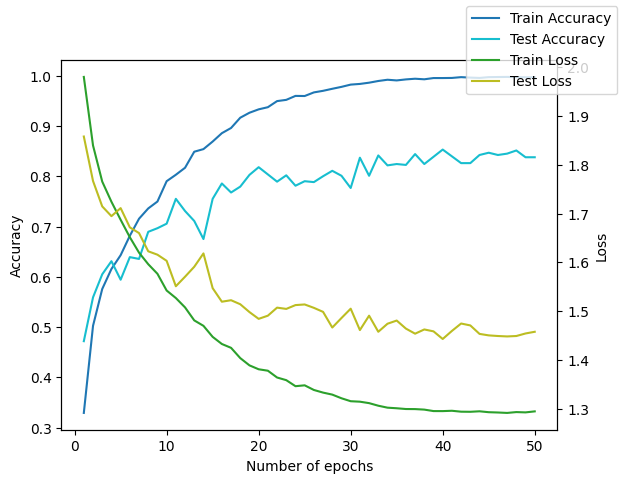

<Figure size 640x480 with 0 Axes>

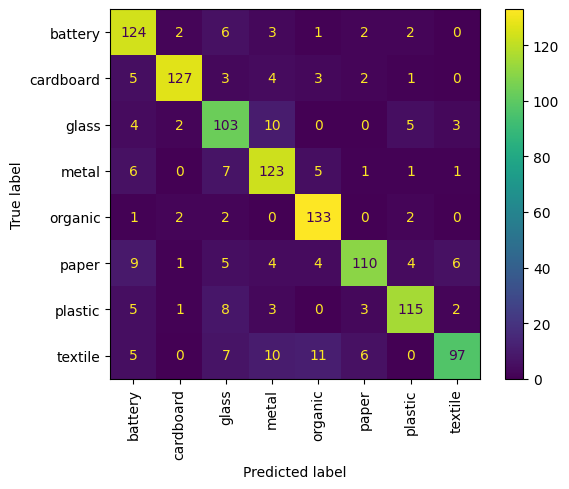

In [31]:
trained_model = train_model(model, full_dataset=False)

########## Save the model ##########
torch.save(trained_model.state_dict(), 'model.pth')


## Submission Kaggle
Cette partie est consacrée à reprendre le modèle entrainé et à prédire une classe sur de nouvelles images non connues et non labellées. Ces prédictions sont exportées dans un fichier .csv avec les identifiants de chaque image afin de pouvoir être évaluées dans le cadre d'une compétiton Kaggle.


In [32]:
class WasteSubmissionDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.image_list = os.listdir(main_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.image_list[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        img_id = os.path.splitext(os.path.basename(img_loc))[0]
        return tensor_image, img_id

test_dataset = WasteSubmissionDataset(main_dir=TEST_DATA, transform=test_transform)
submission_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



Ici, on redéfinit une classe personnalisée pour transformer nos images en Tensors. Les transformations appliquées sont identiques à celles du set de validation.

In [33]:
def generate_submission(model, submission_loader):
    model.eval()

    images_id = []
    predictions = []
    
    with torch.no_grad():
        for batch_idx, (img, tuple_img_id) in enumerate(submission_loader):
            img = img.to(device)
            output = model(img)
            prob = torch.nn.functional.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            for i, img_id  in enumerate(tuple_img_id):
                images_id.append(img_id)
                predictions.append(CLASSES[predicted[i]])
    
    
    df = pd.DataFrame({'ID': images_id, 'Label': predictions})
    df.to_csv('submission.csv', index=False)
    
    print(df.head())

generate_submission(trained_model, submission_loader)

                                     ID    Label
0  69d436c1-429f-4c15-b780-bf599f779ae2  battery
1  02b8a2d3-7444-4e50-9f46-d1fbc7f1c5a4  organic
2  aff9561d-77cc-4d15-a77f-9b3477acb968    paper
3  772a7ee5-97c0-4b4f-82c1-4e36486fb488  battery
4  69e14833-a7be-45e7-8c35-7504245e72ab  textile
